In [1]:
import torch
import os
import re
from typing import Union, List, Optional
from local_text_encoder import encode_prompt
def save_prompt_embeddings(
    prompt_embeds: torch.Tensor,
    pooled_prompt_embeds: torch.Tensor,
    prompt: str,
    save_dir: str = "saved_embeddings",
    verbose: bool = True
):
    """Save prompt embeddings to disk with naming based on sanitized prompt."""
    # Create directory if needed
    os.makedirs(save_dir, exist_ok=True)
    
    # Sanitize prompt for filename
    sanitized_prompt = re.sub(r"[^a-zA-Z0-9_\-]", "", prompt.replace(" ", "_"))[:100]
    base_path = os.path.join(save_dir, f"{sanitized_prompt}")
    
    # Save both embeddings
    torch.save(prompt_embeds, f"{base_path}_prompt.pt")
    torch.save(pooled_prompt_embeds, f"{base_path}_pooled.pt")
    
    if verbose:
        print(f"Saved embeddings for prompt '{prompt}' to {base_path}_*.pt")

def load_prompt_embeddings(
    prompt: str,
    save_dir: str = "saved_embeddings",
    device: Union[str, torch.device] = "cpu",
    verbose: bool = True
) -> Union[tuple, None]:
    """Load embeddings from disk if they exist."""
    # Sanitize prompt for filename
    sanitized_prompt = re.sub(r"[^a-zA-Z0-9_\-]", "", prompt.replace(" ", "_"))[:100]
    base_path = os.path.join(save_dir, f"{sanitized_prompt}")
    
    prompt_path = f"{base_path}_prompt.pt"
    pooled_path = f"{base_path}_pooled.pt"
    
    if os.path.exists(prompt_path) and os.path.exists(pooled_path):
        if verbose:
            print(f"Loading cached embeddings for prompt '{prompt}'")
            
        return (
            torch.load(prompt_path, map_location=device),
            torch.load(pooled_path, map_location=device)
        )
    return None

def get_prompt_embeddings(
    pipe,
    prompt: str,
    save_dir: str = "embeddings_cache",
    device: Optional[torch.device] = None
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Get prompt embeddings from cache or generate new ones.
    
    Args:
        pipe: Diffusion pipeline object
        prompt: Text prompt to encode
        save_dir: Directory to save/load embeddings
        device: Target device for tensors
    
    Returns:
        tuple: (prompt_embeds, pooled_prompt_embeds, text_ids)
    """
    device = device or pipe._execution_device
    cached = load_prompt_embeddings(prompt, save_dir, device=device)
    
    if cached:
        prompt_embeds, pooled_prompt_embeds = cached
        # Recreate text_ids with proper dimensions
        text_ids = torch.zeros(prompt_embeds.shape[1], 3).to(
            device=device,
            dtype=pipe.text_encoder.dtype if pipe.text_encoder else pipe.transformer.dtype
        )
    else:
        # Generate new embeddings
        prompt_embeds, pooled_prompt_embeds, text_ids = encode_prompt(
            pipe=pipe,
            prompt=prompt,
            prompt_2=None
        )
        # Save for future use
        save_prompt_embeddings(prompt_embeds, pooled_prompt_embeds, prompt, save_dir)
        
        # Cleanup model components to save VRAM
    del pipe.text_encoder, pipe.text_encoder_2, pipe.tokenizer, pipe.tokenizer_2
    torch.cuda.empty_cache()

    return prompt_embeds, pooled_prompt_embeds, text_ids

In [2]:
import torch
from local_pipeline import FluxFillPipeline
from diffusers.utils import load_image

pipe = FluxFillPipeline.from_pretrained("black-forest-labs/FLUX.1-Fill-dev", torch_dtype=torch.bfloat16).to("cuda")



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:


prompt_embeds, pooled_prompt_embeds, text_ids = get_prompt_embeddings(
    pipe=pipe,
    prompt="a green paper cup",
    save_dir="my_embeddings",
    device="cuda"  # Optional: force specific device
)

Loading cached embeddings for prompt 'a green paper cup'


/tmp/ipykernel_11867/2897033640.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(prompt_path, map_location=device),
/tmp/ipykernel_11867/2897033640.py:48: Fut

In [4]:
# image = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup.png")
# mask = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup_mask.png")

# image = pipe(
#     prompt=None,
#     prompt_embeds=prompt_embeds, 
#     pooled_prompt_embeds=pooled_prompt_embeds,
#     image=image,
#     mask_image=mask,
#     height=1632,
#     width=1232,
#     guidance_scale=30,
#     num_inference_steps=10,
#     max_sequence_length=512,
#     generator=torch.Generator("cpu").manual_seed(0)
# ).images[0]
# image


In [5]:
import torch
import torch.nn as nn

def quantize_4b_blocks(tensor, block_size, q_bit=4):
    """
    Quantizes the tensor in blocks into 4-bit values and packs two values per byte.
    
    Args:
        tensor (torch.Tensor): The tensor to quantize.
        block_size (int): Number of elements per block (must be even for 4-bit packing).
        q_bit (int): Bit width for quantization (should be 4 for this function).
        
    Returns:
        packed (torch.ByteTensor): Tensor containing the packed 4-bit values.
        scales (torch.Tensor): Per-block scaling factors.
        original_shape (torch.Size): The original shape of the tensor.
    """
    if q_bit != 4:
        raise ValueError("This function is specifically for 4-bit quantization.")
    
    # For 4-bit symmetric quantization (e.g. values in [-7, 7])
    qmax = 2**(q_bit-1) - 1  # 2^(4-1)-1 = 7
    original_shape = tensor.shape
    flattened = tensor.flatten()
    num_elements = flattened.numel()
    
    # Ensure the total number of elements is divisible by block_size.
    if num_elements % block_size != 0:
        raise ValueError(f"Tensor size {num_elements} must be divisible by block_size {block_size}")
    
    # For packing into 4-bit (2 values per byte), we require block_size to be even.
    if block_size % 2 != 0:
        raise ValueError("For 4-bit quantization, block_size must be even to allow packing pairs.")
    
    # Reshape into blocks: shape (num_blocks, block_size)
    blocks = flattened.view(-1, block_size)
    
    # Compute per‑block maximum absolute values (avoid division by zero)
    max_abs = torch.max(torch.abs(blocks), dim=1).values
    max_abs = torch.clamp(max_abs, min=1e-8)
    scales = max_abs / qmax  # Scale factor per block
    
    # Quantize: scale the blocks, round, and clamp to [-qmax, qmax]
    scaled_blocks = blocks / scales.unsqueeze(1)  # Broadcasting the scale per block
    quantized = torch.round(scaled_blocks).clamp(-qmax, qmax).to(torch.int8)
    
    # For blocks that are (nearly) all zeros, set scale and quantized values to zero.
    zero_mask = (max_abs < 1e-8)
    scales[zero_mask] = 0.0
    quantized[zero_mask] = 0

    # Convert signed 4-bit numbers to an unsigned representation.
    # For a 4-bit two's complement representation: if value is negative, add 16.
    quantized_unsigned = torch.where(quantized < 0, quantized + 16, quantized).to(torch.uint8)
    
    # Pack every two 4-bit values into one byte.
    # First, reshape the last dimension to pair up values: shape (num_blocks, block_size//2, 2)
    blocks_reshaped = quantized_unsigned.view(-1, block_size // 2, 2)
    # Pack: first nibble goes into the high 4 bits, second nibble into the low 4 bits.
    packed = (blocks_reshaped[:, :, 0] << 4) | blocks_reshaped[:, :, 1]  # shape: (num_blocks, block_size//2)
    
    return packed, scales, original_shape

def dequantize_4b_blocks(packed, scales, block_size, original_shape):
    """
    Unpacks and dequantizes the 4-bit packed tensor.
    
    Args:
        packed (torch.ByteTensor): Packed tensor of shape (num_blocks, block_size//2)
        scales (torch.Tensor): Per-block scales.
        block_size (int): The original block size (must be even).
        original_shape (torch.Size): The original shape of the tensor.
    
    Returns:
        dequantized (torch.Tensor): The dequantized tensor with original shape.
    """
    num_blocks = packed.shape[0]
    
    # Unpack: extract high and low nibbles from each byte.
    high = (packed >> 4) & 0xF  # High 4 bits
    low  = packed & 0xF         # Low 4 bits
    
    # Reassemble the two nibbles back into a tensor of shape (num_blocks, block_size)
    # by interleaving the high and low parts.
    unpacked = torch.stack([high, low], dim=2).reshape(num_blocks, block_size)
    
    # Convert from unsigned (0–15) back to signed 4-bit representation.
    # For values 8 and above, subtract 16.
    signed_unpacked = torch.where(unpacked >= 8, unpacked - 16, unpacked).to(torch.int8)
    
    # Dequantize by multiplying with the per‑block scales.
    dequantized_blocks = signed_unpacked* scales.unsqueeze(1)
    
    return dequantized_blocks.view(original_shape)

# An example modified model that uses 4-bit quantization for the "remainder".
class SDV_FC_4b(nn.Module):
    def __init__(self, l1, l2, bias, remainder, block_size, q_bit=4):
        """
        Initializes the model.
        
        Args:
            l1, l2, bias: Standard parameters.
            remainder: The tensor to be quantized in 4-bit.
            block_size: The block size used for per-block quantization.
            q_bit: Should be 4.
        """
        super(SDV_FC_4b, self).__init__()
        self.l1 = nn.Parameter(l1.clone())
        self.l2 = nn.Parameter(l2.clone())
        self.bias = nn.Parameter(bias.clone())
        self.block_size = block_size
        
        if q_bit != 4:
            raise ValueError("This model is set up for 4-bit quantization only.")
        
        # Quantize the remainder using 4-bit quantization.
        quantized_remainder, scales, original_shape = quantize_4b_blocks(remainder, block_size, q_bit)
        # Save the packed quantized tensor and scales as buffers.
        self.register_buffer('quantized_remainder', quantized_remainder)
        self.register_buffer('scales', scales)
        # Save the original shape as an attribute (for dequantization)
        self.original_shape = original_shape
        
        # Optionally delete the original tensors to free memory.
        del l1, l2, bias, remainder
        
    def forward(self, x):
        # Compute the standard low-rank output.
        standard_out = x @ self.l2.t() @ self.l1.t()
        
        # Dequantize the packed remainder.
        dequantized_remainder = dequantize_4b_blocks(
            self.quantized_remainder, self.scales, self.block_size, self.original_shape
        )
        remainder_out = x @ dequantized_remainder.t()
        
        # Combine outputs along with bias.
        out = remainder_out + standard_out + self.bias
        return out



In [6]:
import torch
import torch.nn as nn

def quantize_8b_blocks(tensor, block_size , q_bit):
    qmax = 2**(q_bit-1)-1  # 2^(8-1) - 1 for signed 8-bit quantization
    original_shape = tensor.shape
    flattened = tensor.flatten()
    num_elements = flattened.numel()
    
    # Ensure divisibility
    if num_elements % block_size != 0:
        raise ValueError(f"Tensor size {num_elements} must be divisible by block_size {block_size}")
    
    # Reshape into (num_blocks, block_size)
    blocks = flattened.view(-1, block_size)
    
    # Vectorized max computation (per block)
    max_abs = torch.max(torch.abs(blocks), dim=1).values
    max_abs = torch.clamp(max_abs, min=1e-8)  # Avoid division by zero
    
    # Compute scales (vectorized)
    scales = max_abs / qmax
    
    # Quantize all blocks simultaneously
    scaled_blocks = blocks / scales.unsqueeze(1)  # Broadcast scaling
    quantized = torch.round(scaled_blocks).clamp(-qmax, qmax).to(torch.int8)
    
    # Handle zero blocks (where original max was zero)
    zero_mask = (max_abs < 1e-8)
    scales[zero_mask] = 0.0
    quantized[zero_mask] = 0
    
    return quantized.view(original_shape), scales

def dequantize_8b_blocks(indices, scales, block_size):
    original_shape = indices.shape
    indices_flat = indices.view(-1, block_size)
    scales_expanded = scales.unsqueeze(1)  # For broadcasting
    dequantized = indices_flat * scales_expanded
    return dequantized.view(original_shape)
class SDV_FC(nn.Module):
    def __init__(self, l1, l2, bias, remainder, block_size , q_bit):
        super(SDV_FC, self).__init__()
        self.l1 = nn.Parameter(l1.clone())
        self.l2 = nn.Parameter(l2.clone())
        self.bias = nn.Parameter(bias.clone())
        self.block_size = block_size
        
        # Quantize remainder into blocks
        quantized_remainder, scales = quantize_8b_blocks(remainder, block_size , q_bit)
        
        # Register buffers for quantized tensor and scales
        self.register_buffer('quantized_remainder', quantized_remainder)
        self.register_buffer('scales', scales)
        
        del l1, l2, bias, remainder
        
    def forward(self, x):
        # Compute standard low-rank part
        standard_out = x @ self.l2.t() @ self.l1.t()
        
        # Dequantize the remainder
        dequantized_remainder = dequantize_8b_blocks(
            self.quantized_remainder, self.scales, self.block_size
        )
        remainder_out = x @ dequantized_remainder.t()
        
        # Combine outputs
        out = remainder_out + standard_out + self.bias
        return out
def SDV_FC_FullyConnectedLayers(fc_weight, fc_bias, block_size=64 , q_bit=8,rank=None):
    # Compute SVD
    U, S, Vh = torch.linalg.svd(fc_weight.float(), full_matrices=False)
    
    # Verify S is sorted
    assert torch.all(S[:-1] >= S[1:]), "Singular values not sorted!"
    
    # Take components corresponding to non-zero singular values
    U_r = U[:, :rank].to(torch.bfloat16)
    S_r = S[:rank].to(torch.bfloat16)
    V_r = Vh[:rank, :].to(torch.bfloat16)
    
    # Create scaled matrices
    l1 = U_r @ torch.diag(S_r)
    l2 = V_r
    remainder = fc_weight-l1 @ l2
    del U, S, Vh, fc_weight
    torch.cuda.empty_cache()  # Clear GPU cache
    gc.collect()  # Force garbage collection
    return SDV_FC_4b(l1, l2, fc_bias, remainder , block_size , q_bit)


In [41]:
import torch
import torch.nn as nn
from tqdm import tqdm
import gc
from diffusers.models.attention import FeedForward , GELU
from diffusers.models.attention_processor import Attention 
from diffusers.models.transformers.transformer_flux import FluxSingleTransformerBlock
from diffusers.models.normalization import AdaLayerNormZeroSingle , AdaLayerNormZero

from diffusers.models.embeddings import TimestepEmbedding
allowed_module=[Attention , AdaLayerNormZeroSingle , AdaLayerNormZero , FeedForward , nn.ModuleList , GELU , TimestepEmbedding]

def count_linear_layers(module):
    """Helper to count total nn.Linear layers in a module hierarchy."""
    count = 0
    for child in module.children():
        if isinstance(child, nn.Linear):
            count += 1
        else:
            count += count_linear_layers(child)
    return count

def convert_linear_layers_to_sdv_fc(model, rank=None, progress_bar=None , q_bit=8):
    """Recursively replace Linear layers with custom SDV_FC layers."""
    for name, module in list(model.named_children()):
        if isinstance(module, nn.Linear):
            # Extract parameters
            fc_weight = module.weight.data.detach()
            fc_bias = module.bias.data.detach() if module.bias is not None else None

            # Replace with custom layer
            sdv_fc_layer = SDV_FC_FullyConnectedLayers(fc_weight, fc_bias, rank=rank , q_bit=q_bit)
            setattr(model, name, sdv_fc_layer)
            
            # Cleanup
            del module, fc_weight, fc_bias
            torch.cuda.empty_cache()
            gc.collect()
            
            # Update progress bar
            if progress_bar:
                progress_bar.update(1)
                
        elif isinstance(module, nn.Module):
            # Recurse into submodules
            convert_linear_layers_to_sdv_fc(module, rank=rank, progress_bar=progress_bar , q_bit=q_bit)
    
    return model

# Usage example
your_model=pipe.transformer
total_linear = count_linear_layers(your_model)

rank=16
q_bit=4
with tqdm(total=total_linear, desc="Converting Linear Layers") as pbar:
    converted_model = convert_linear_layers_to_sdv_fc(your_model, rank=16, progress_bar=pbar , q_bit=q_bit)

your_model=pipe.transformer.transformer_blocks
total_linear = count_linear_layers(your_model)
with tqdm(total=total_linear, desc="Converting Linear Layers") as pbar:
    converted_model = convert_linear_layers_to_sdv_fc(your_model, rank=16, progress_bar=pbar , q_bit=q_bit)

your_model=pipe.transformer.time_text_embed
total_linear = count_linear_layers(your_model)
with tqdm(total=total_linear, desc="Converting Linear Layers") as pbar:
    converted_model = convert_linear_layers_to_sdv_fc(your_model, rank=16, progress_bar=pbar , q_bit=q_bit)

Converting Linear Layers: 100%|██████████| 82/82 [02:18<00:00,  1.69s/it]
Converting Linear Layers: 0it [00:00, ?it/s]
Converting Linear Layers: 0it [00:00, ?it/s]


In [36]:
pipe.transformer.time_text_embed

CombinedTimestepGuidanceTextProjEmbeddings(
  (time_proj): Timesteps()
  (timestep_embedder): TimestepEmbedding(
    (linear_1): SDV_FC_4b()
    (act): SiLU()
    (linear_2): SDV_FC_4b()
  )
  (guidance_embedder): TimestepEmbedding(
    (linear_1): SDV_FC_4b()
    (act): SiLU()
    (linear_2): SDV_FC_4b()
  )
  (text_embedder): PixArtAlphaTextProjection(
    (linear_1): Linear(in_features=768, out_features=3072, bias=True)
    (act_1): SiLU()
    (linear_2): Linear(in_features=3072, out_features=3072, bias=True)
  )
)

In [42]:
torch.cuda.empty_cache()

In [9]:
# Create a random 256x256 matrix.
matrix = torch.randn(256, 256)
block_size = 8  # Must be even

# Compute original Frobenius norm.
fro_norm_original = torch.norm(matrix, p='fro')

# --------- 8-bit Quantization ---------
quantized_8b, scales_8b = quantize_8b_blocks(matrix, block_size, q_bit=4)
reconstructed_8b = dequantize_8b_blocks(quantized_8b, scales_8b, block_size)
error_8b = torch.norm(matrix - reconstructed_8b, p='fro')
relative_error_8b = error_8b / fro_norm_original

# --------- 4-bit Quantization ---------
packed_4b, scales_4b, orig_shape_4b = quantize_4b_blocks(matrix, block_size, q_bit=4)
reconstructed_4b = dequantize_4b_blocks(packed_4b, scales_4b, block_size, orig_shape_4b)
error_4b = torch.norm(matrix - reconstructed_4b, p='fro')
relative_error_4b = error_4b / fro_norm_original

# Print results.
print("Original Frobenius norm: {:.6f}".format(fro_norm_original.item()))
print("\n=== 8-bit Quantization ===")
print("Reconstruction error (Frobenius norm): {:.6f}".format(error_8b.item()))
print("Relative error: {:.6f}".format(relative_error_8b.item()))
print("\n=== 4-bit Quantization ===")
print("Reconstruction error (Frobenius norm): {:.6f}".format(error_4b.item()))
print("Relative error: {:.6f}".format(relative_error_4b.item()))

Original Frobenius norm: 255.106186

=== 8-bit Quantization ===
Reconstruction error (Frobenius norm): 18.338741
Relative error: 0.071887

=== 4-bit Quantization ===
Reconstruction error (Frobenius norm): 18.338741
Relative error: 0.071887


In [40]:
pipe.transformer

FluxTransformer2DModel(
  (pos_embed): FluxPosEmbed()
  (time_text_embed): CombinedTimestepGuidanceTextProjEmbeddings(
    (time_proj): Timesteps()
    (timestep_embedder): TimestepEmbedding(
      (linear_1): SDV_FC_4b()
      (act): SiLU()
      (linear_2): SDV_FC_4b()
    )
    (guidance_embedder): TimestepEmbedding(
      (linear_1): SDV_FC_4b()
      (act): SiLU()
      (linear_2): SDV_FC_4b()
    )
    (text_embedder): PixArtAlphaTextProjection(
      (linear_1): Linear(in_features=768, out_features=3072, bias=True)
      (act_1): SiLU()
      (linear_2): Linear(in_features=3072, out_features=3072, bias=True)
    )
  )
  (context_embedder): Linear(in_features=4096, out_features=3072, bias=True)
  (x_embedder): Linear(in_features=384, out_features=3072, bias=True)
  (transformer_blocks): ModuleList(
    (0-18): 19 x FluxTransformerBlock(
      (norm1): AdaLayerNormZero(
        (silu): SiLU()
        (linear): SDV_FC_4b()
        (norm): LayerNorm((3072,), eps=1e-06, elementwise_a

In [10]:
# import numpy as np


# rawvector=pipe.transformer.single_transformer_blocks[0].attn.to_q
# flattened_tensor = dequantize_8b_codebook(rawvector.remainder ,rawvector.min_val , rawvector.scale).float().cpu().numpy().flatten()

# # Subsample if tensor has >1M elements
# max_samples = 100_000  # Adjust based on your system's memory
# if len(flattened_tensor) > max_samples:
#     rng = np.random.default_rng(seed=4)  # For reproducibility
#     flattened_tensor = rng.choice(flattened_tensor, size=max_samples, replace=False)


# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# ax = sns.histplot(
#     flattened_tensor,
#     kde=True,
#     stat="density",
#     bins="auto",  # Let matplotlib choose optimal bin count
#     kde_kws={"bw_adjust": 0.5}  # Reduce KDE smoothness for sharper features
# )
# plt.title("Tensor Distribution (Subsampled)")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

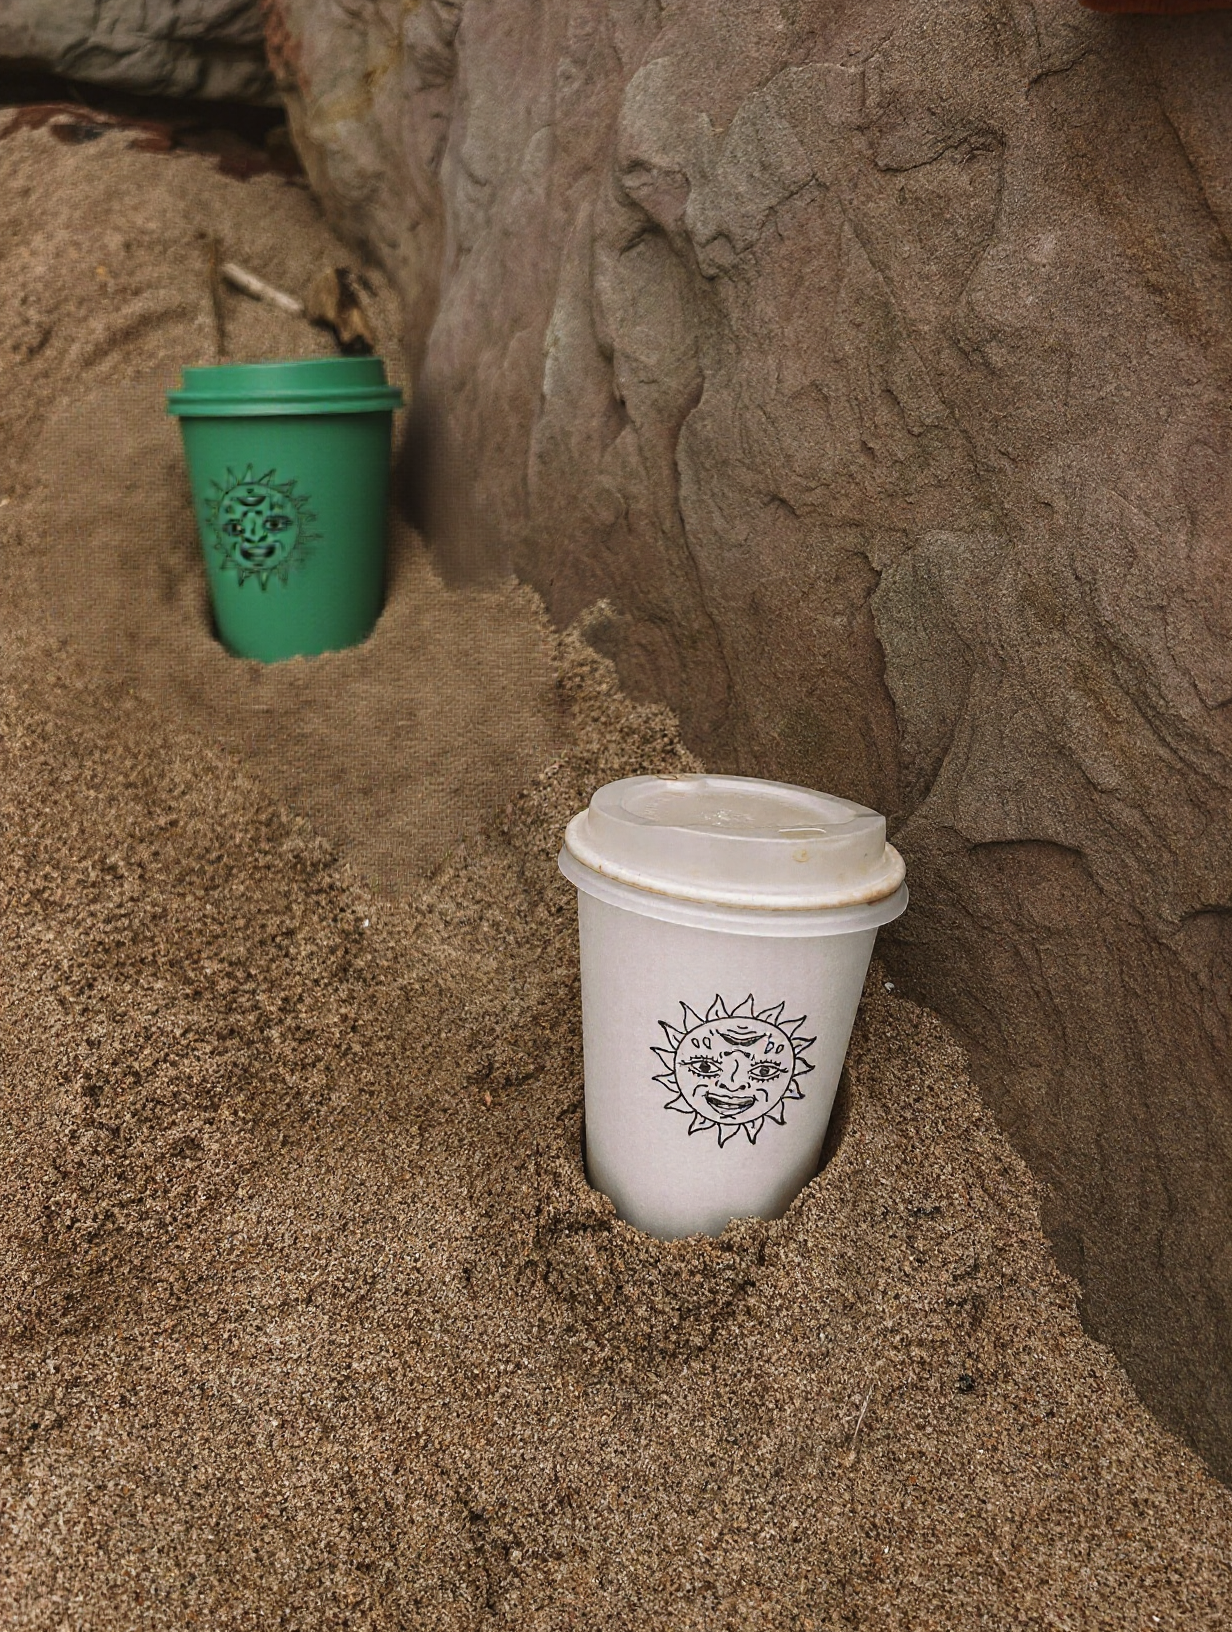

In [43]:
image = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup.png")
mask = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup_mask.png")

image = pipe(
    prompt=None,
    prompt_embeds=prompt_embeds, 
    pooled_prompt_embeds=pooled_prompt_embeds,
    image=image,
    mask_image=mask,
    height=1632,
    width=1232,
    guidance_scale=30,
    num_inference_steps=10,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image


In [44]:
torch.cuda.empty_cache()

In [45]:
import torch

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.max_memory_allocated(i) / 1024**2:.2f} MB")
else:
    print("No GPU found.")


GPU 0: 6410.49 MB / 32200.54 MB
